In [2]:
import matplotlib.pyplot as plt
import os
import pandas as pd

In [3]:
output_dir = "graficos_pisos_edificio"
os.makedirs(output_dir, exist_ok=True)

In [3]:
nepal = pd.read_csv("eq2015.csv")
fuente_1 = "https://www.kaggle.com/datasets/sanskarnegi/nepal-earthquake-2015"

In [5]:
distritos = nepal["district_name"].unique()
distritos

array(['OKHALDHUNGA', 'SINDHULI', 'RAMECHHAP', 'DOLAKHA', 'SINDHUPALCHOK',
       'KAVRE', 'NUWAKOT', 'RASUWA', 'DHADING', 'MAKWANPUR', 'GORKHA'],
      dtype=object)

In [6]:
graficos_por_distrito = {}

In [8]:
for distrito in distritos:
    df_distrito = nepal[nepal["district_name"] == distrito]
    df_grouped = df_distrito.groupby(["count_floors_pre_eq", "damage_grade"]).size().unstack(fill_value=0)
    
    # Asegurar presencia de todos los grados de daño
    todos_los_grados = ["Grade 1", "Grade 2", "Grade 3", "Grade 4", "Grade 5"]
    df_grouped = df_grouped.reindex(columns=todos_los_grados, fill_value=0)

    # Normalizar las filas para que cada barra tenga altura total 1
    df_normalized = df_grouped.div(df_grouped.sum(axis=1), axis=0).fillna(0)

    # Crear la figura
    fig, ax = plt.subplots(figsize=(13, 10))
    df_normalized.plot(kind='bar', stacked=True, colormap='viridis', ax=ax,legend=False)

    # Etiquetas
    plt.xlabel('Número de pisos')
    plt.ylabel('Número de edificios')
    plt.title(f'Distrito: {distrito}')
    plt.xticks(rotation=0)
    ax.set_ylim(0, 1)

    for i, (idx, row) in enumerate(df_normalized.iterrows()):
        y_offset = 0
        for damage_grade, value in row.items():
            if value > 0:
                ax.text(
                    i + 0.48,
                    y_offset + value / 2, 
                    f"{value * 100:.1f}%", 
                    ha='right', 
                    va='center',
                    fontsize=7,
                    color='black'
                )
            y_offset += value
    # Guardar la imagen en memoria
    img_path = os.path.join(output_dir, f"{distrito}.png")
    plt.savefig(img_path, bbox_inches="tight", dpi=150)
    plt.close(fig)

    # Guardar ruta de la imagen
    graficos_por_distrito[distrito] = img_path

In [4]:
nepal["pisos_agrupados"] = pd.cut(
    nepal["count_floors_pre_eq"],
    bins=[0, 1, 2, 3, float("inf")],
    labels=["1 piso", "2 pisos", "3 pisos", "4+ pisos"],
    right=True
)

In [6]:
tabla_contingencia = pd.crosstab(nepal["pisos_agrupados"], nepal["damage_grade"])
print(tabla_contingencia)

damage_grade     Grade 1  Grade 2  Grade 3  Grade 4  Grade 5
pisos_agrupados                                             
1 piso             30774    21147    18018    15630    33330
2 pisos            37917    54233    93555   120727   161671
3 pisos             6859    10271    23613    46332    79918
4+ pisos            3265     1606     1226     1155      847


In [8]:
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)

print(f"Chi² = {chi2:.2f}")
print(f"Grados de libertad = {dof}")
print(f"p-valor = {p:.4e}")

Chi² = 73130.16
Grados de libertad = 12
p-valor = 0.0000e+00


In [9]:
import numpy as np
import seaborn as sns

In [ ]:
# Calcular residuos estandarizados
residuos = (tabla_contingencia - expected) / np.sqrt(expected)

C:\Users\inilo\AppData\Local\Temp\ipykernel_43780\3695747132.py:7: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inilo\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


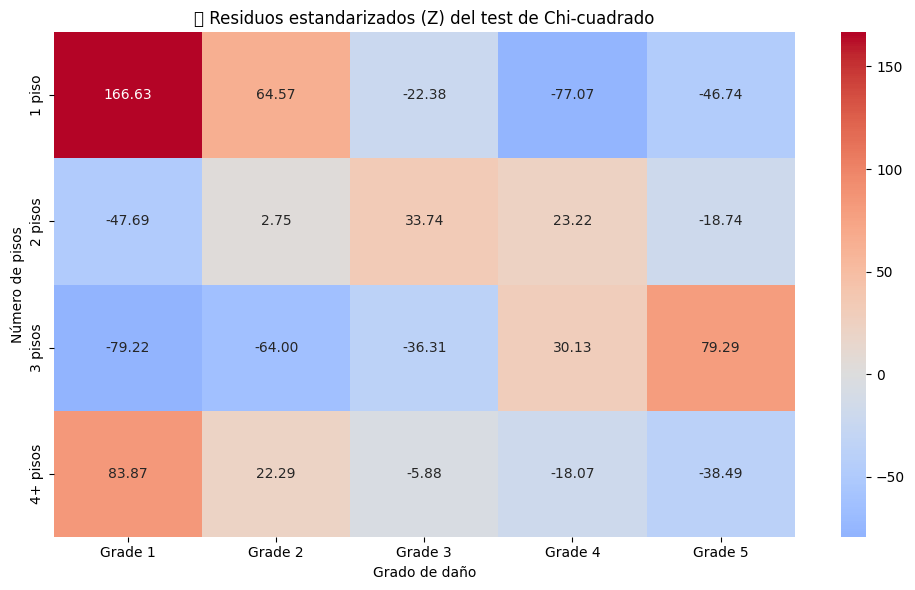

In [11]:
# Crear heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(residuos, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("🔍 Residuos estandarizados (Z) del test de Chi-cuadrado")
plt.xlabel("Grado de daño")
plt.ylabel("Número de pisos")
plt.tight_layout()
plt.show()